## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
if not os.path.isfile('./AB_NYC_2019.csv'):
    !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [3]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

Now, use `DictVectorizer` to turn train and validation into matrices:

In [4]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

dicts_train = df_train.to_dict(orient='records')
X_train = dv.fit_transform(dicts_train)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

print(export_text(dt, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

### Answer 1: 
`room_type=Entire home/apt`

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [13]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from math import sqrt

rf = RandomForestRegressor(n_estimators=10,
                           random_state=1,
                           n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

rmse = sqrt(mean_squared_error(y_val,y_pred))
round(rmse,3)

0.462

What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

### Answer 2
RMSE = 0.459 (aprox)

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [19]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rmse = round(sqrt(mean_squared_error(y_val,y_pred)),3)
    
    scores.append((n, rmse))
    print(n,rmse)
scores

10 0.462
20 0.448
30 0.446
40 0.444
50 0.442
60 0.442
70 0.441
80 0.441
90 0.441
100 0.44
110 0.439
120 0.439
130 0.439
140 0.439
150 0.439
160 0.439
170 0.439
180 0.439
190 0.439
200 0.439


[(10, 0.462),
 (20, 0.448),
 (30, 0.446),
 (40, 0.444),
 (50, 0.442),
 (60, 0.442),
 (70, 0.441),
 (80, 0.441),
 (90, 0.441),
 (100, 0.44),
 (110, 0.439),
 (120, 0.439),
 (130, 0.439),
 (140, 0.439),
 (150, 0.439),
 (160, 0.439),
 (170, 0.439),
 (180, 0.439),
 (190, 0.439),
 (200, 0.439)]

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

### Answer 3
RMSE stop improving in `n_estimator = 120`

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [24]:
scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = sqrt(mean_squared_error(y_val,y_pred))
        
        scores.append((d, n, round(rmse,3)))
        
        print('max_depth', 'n_estimators', 'rmse')
        print(d,n,rmse)

max_depth n_estimators rmse
10 10 0.44555264855924354
max_depth n_estimators rmse
10 20 0.4420087608705588
max_depth n_estimators rmse
10 30 0.4413808076445009
max_depth n_estimators rmse
10 40 0.44147246709402543
max_depth n_estimators rmse
10 50 0.4410673887594956
max_depth n_estimators rmse
10 60 0.4410459421233984
max_depth n_estimators rmse
10 70 0.4407598704010177
max_depth n_estimators rmse
10 80 0.4405950365838957
max_depth n_estimators rmse
10 90 0.4403250798157756
max_depth n_estimators rmse
10 100 0.4401137602802354
max_depth n_estimators rmse
10 110 0.4400259912335258
max_depth n_estimators rmse
10 120 0.4398178667293093
max_depth n_estimators rmse
10 130 0.4398547755113232
max_depth n_estimators rmse
10 140 0.439849858533311
max_depth n_estimators rmse
10 150 0.4396900165901451
max_depth n_estimators rmse
10 160 0.4396442598915558
max_depth n_estimators rmse
10 170 0.43962394971115537
max_depth n_estimators rmse
10 180 0.4397169310258638
max_depth n_estimators rmse
10 190 

In [25]:
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

In [26]:
df_scores_pivot = df_scores.pivot(index='n_estimators', columns=['max_depth'], values=['rmse'])
df_scores_pivot.round(3)

rmse                     
max_depth        10     15     20     25
n_estimators                            
10            0.446  0.450  0.458  0.461
20            0.442  0.441  0.446  0.447
30            0.441  0.440  0.443  0.445
40            0.441  0.439  0.442  0.443
50            0.441  0.438  0.441  0.442
60            0.441  0.438  0.440  0.442
70            0.441  0.437  0.440  0.441
80            0.441  0.437  0.440  0.441
90            0.440  0.437  0.439  0.440
100           0.440  0.437  0.439  0.440
110           0.440  0.436  0.438  0.439
120           0.440  0.436  0.438  0.439
130           0.440  0.436  0.438  0.439
140           0.440  0.436  0.438  0.439
150           0.440  0.436  0.438  0.439
160           0.440  0.436  0.438  0.439
170           0.440  0.436  0.438  0.439
180           0.440  0.436  0.438  0.439
190           0.440  0.436  0.438  0.439
200           0.440  0.436  0.438  0.439

<AxesSubplot:xlabel='None-max_depth', ylabel='n_estimators'>

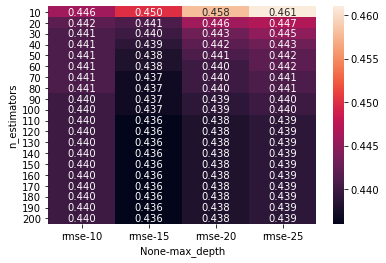

In [27]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

What's the best `max_depth`:

* 10
* 15
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

### Answer 4
The best `max_depth` is 15

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [33]:
rf = RandomForestRegressor(n_estimators=10,
                           max_depth=20,
                           random_state=1,
                           n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
rmse = sqrt(mean_squared_error(y_val,y_pred))

In [41]:
# rf.feature_importances_
forest_importances = pd.Series(rf.feature_importances_, index=dv.get_feature_names())
forest_importances

availability_365                     0.076264
calculated_host_listings_count       0.030102
latitude                             0.152775
longitude                            0.154101
minimum_nights                       0.053252
neighbourhood_group=Bronx            0.000265
neighbourhood_group=Brooklyn         0.000966
neighbourhood_group=Manhattan        0.034047
neighbourhood_group=Queens           0.001166
neighbourhood_group=Staten Island    0.000084
number_of_reviews                    0.041594
reviews_per_month                    0.054430
room_type=Entire home/apt            0.391898
room_type=Private room               0.004032
room_type=Shared room                0.005023
dtype: float64

<AxesSubplot:>

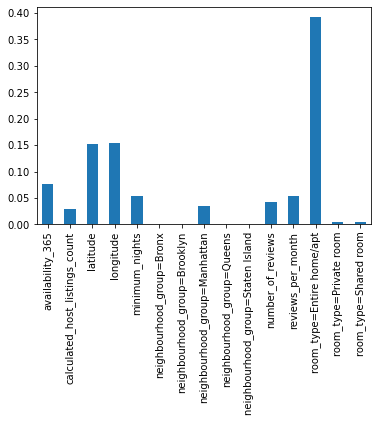

In [43]:
forest_importances.plot.bar()

What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`

### Answer 5
The most important feature is `room_type=Entire home/apt`

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [44]:
!pip install xgboost
import xgboost as xgb

In [45]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [46]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [52]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [53]:
scores = {}

In [59]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

Now change `eta` first to `0.1` and then to `0.01`

In [60]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

In [61]:
scores.keys()

dict_keys(['eta=0.3', 'eta=0.1', 'eta=0.01'])

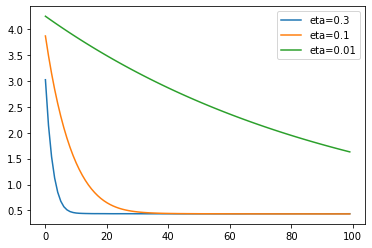

In [62]:
etas = ['eta=0.3', 'eta=0.1', 'eta=0.01']
for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)
plt.legend()

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* 0.01

 ### Answer 6
 The best RMSE score on the validation dataset is leaded with `eta = 0.3`

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

